In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


In [7]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
import tensorflow as tf

# --- Load CSVs ---
train_df = pd.read_csv("train_data.csv")
test_df  = pd.read_csv("test_data.csv")

# --- Split features/labels ---
X_train = train_df.drop(['label'], axis=1).values.astype("float32")
y_train = train_df['label'].values
X_test  = test_df.drop(['label'], axis=1).values.astype("float32")
y_test  = test_df['label'].values

# --- Normalize ---
X_train /= 255.0
X_test  /= 255.0

# --- Reshape to (H, W, C) ---
X_train = X_train.reshape(-1, 32, 32, 3)
X_test  = X_test.reshape(-1, 32, 32, 3)

# (Optional) upscale to 224x224 for VGG16 features:
# X_train = tf.image.resize(X_train, (224, 224)).numpy()
# X_test  = tf.image.resize(X_test,  (224, 224)).numpy()
# input_shape = (224, 224, 3)
input_shape = (32, 32, 3)

# --- One-hot labels (10 classes) ---
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

# --- Base model ---
base = VGG16(
    weights="imagenet",          # or your local .h5 path if you prefer
    include_top=False,
    input_shape=input_shape
)
for layer in base.layers:
    layer.trainable = False

# --- Head ---
model = Sequential([
    base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')   # <-- 10 classes
])

model.compile(optimizer=Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# --- Train (now pass X and y) ---
model.fit(X_train, y_train,
          validation_split=0.2,
          epochs=5,
          batch_size=64,
          shuffle=True)

# --- Evaluate ---
model.evaluate(X_test, y_test, verbose=0)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 156ms/step - accuracy: 0.3899 - loss: 1.7169 - val_accuracy: 0.5561 - val_loss: 1.2600
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - accuracy: 0.5459 - loss: 1.2894 - val_accuracy: 0.5754 - val_loss: 1.1983
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 183ms/step - accuracy: 0.5847 - loss: 1.2048 - val_accuracy: 0.6012 - val_loss: 1.1530
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 113s 181ms/step - accuracy: 0.5955 - loss: 1.1519 - val_accuracy: 0.6030 - val_loss: 1.1422
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 186ms/step - accuracy: 0.6120 - loss: 1.1107 - val_accuracy: 0.6076 - val_loss: 1.1265


[1.1411081552505493, 0.600600004196167]

In [8]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.6006 - loss: 1.1333
Validation Loss: 1.1411
Validation Accuracy: 0.6006


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

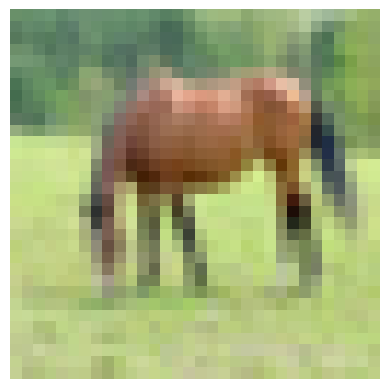

In [9]:
# X_test was already resized to (n, 64, 64, 3) earlier.
# Don't overwrite the existing 'img' variable (it is used in other cells).
# Display the 60th test image directly.
import matplotlib.pyplot as plt
plt.imshow(X_test[60])
plt.axis('off')

In [10]:
# Predict using the 60th test image (not the one-hot label).
# Add a batch dimension so the input shape is (1, 64, 64, 3).
output = model.predict(np.expand_dims(X_test[60], axis=0))
predicted_class = np.argmax(output, axis=1)[0]
print("Predicted class:", predicted_class)
print("True class:", np.argmax(y_test[60]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted class: 7
True class: 7


In [11]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])
plt.show()

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train','val'])
plt.show()

NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>

In [12]:
# ------------------------------
# e) Fine-tune (optional) — unfreeze few deeper conv layers
# ------------------------------
for layer in base.layers[-4:]:   #a unfreeze last 4 conv blocks
    layer.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-5),
              metrics=['accuracy'])

history2 = model.fit(train_data,
                     validation_data=val_data,
                     epochs=5)

NameError: name 'train_data' is not defined